In [1]:
%matplotlib inline

In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from lightkurve import TessLightCurveFile
from astropy.coordinates import SkyCoord
import astropy.units as u
import lightkurve

import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
import theano
from scipy.signal import savgol_filter
import pandas as pd
from astropy.time import Time

In [3]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)

0.1.6
1.0.4
3.6


In [4]:
target = 'AU Mic'
lcf = lightkurve.search_lightcurvefile(target).download(quality_bitmask='hard',)
lc = lcf.get_lightcurve('PDCSAP_FLUX').normalize()

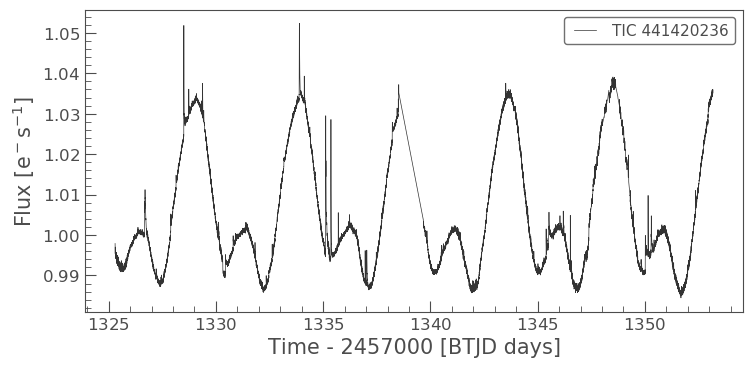

In [5]:
lc_hdr = lcf.header(ext=1)
lc.plot(normalize=False)

In [6]:
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
ref_time = 0.5 * (lc.time.min() + lc.time.max())
flux = (lc.flux - 1.0) * 1e3
time = lc.time
flux_err = lc.flux_err
m = np.isfinite(time) & np.isfinite(flux)
time = time[m]
flux = flux[m]
flux_err = flux_err[m]

In [7]:
# Identify outliers
m = np.ones(len(flux), dtype=bool)
for i in range(20):
    y_prime = np.interp(time, time[m], flux[m])
    smooth = savgol_filter(y_prime, 301, polyorder=3)
    resid = flux - smooth
    sigma = np.sqrt(np.mean(resid**2))
    m0 = resid < sigma*1.
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0

(1330, 1331)

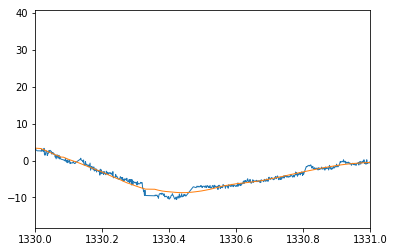

In [8]:
plt.plot(time[m], flux[m], lw=1)
plt.plot(time, smooth, lw=1)
plt.xlim(1330,1331)

In [9]:
spitzer = pd.read_csv('spitzer.csv')
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)
flux_err = np.ascontiguousarray(flux_err[m], dtype=np.float64)

x = time
y = flux
yerr = flux_err

In [10]:
x_spitzer = Time(spitzer.BMJD, format='mjd', scale='tdb').jd - 2457000 - ref_time
y_spitzer = ((spitzer.SAP_flux.values - 1.0) * 1.E3) - 1.0 # there is an offset of 1 ppm in the spitzer sap data
yerr_spitzer = np.ones_like(y_spitzer) * np.std(y_spitzer[1700:2000])

texp_spitzer = np.median(np.diff(x_spitzer))

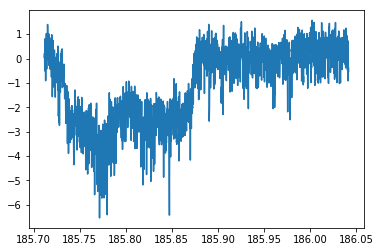

In [11]:
plt.plot(x_spitzer, y_spitzer)

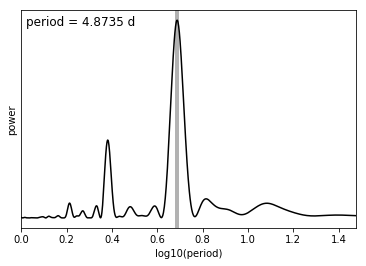

In [15]:
results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=1.0, max_period=30.0,
    samples_per_peak=50)

peak = results["peaks"][0]
ls_period = peak["period"]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(ls_period), color="k", lw=4, alpha=0.3)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.annotate("period = {0:.4f} d".format(ls_period),
             (0, 1), xycoords="axes fraction",
             xytext=(5, -5), textcoords="offset points",
             va="top", ha="left", fontsize=12)
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power");

In [23]:
def build_model(mask=None, mask_spitzer=None, start=None):
    guess_p_period = 8.463211#, 30.537
    guess_p_t0 = -8.849918#, 2.9955
    guess_p_depth = 0.05#, 0.02
    if mask is None:
        mask = np.ones_like(x, dtype=bool)
        mask_spitzer = np.ones_like(x_spitzer, dtype=bool)
    with pm.Model() as model:

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=6.5, sd=15.0)
        mean_spitzer = pm.Normal("mean_spitzer", mu=0, sd=1.0)

        # A jitter term describing excess white noise
        logs2 = pm.Normal("logs2", mu=-2.8, sd=2.0)
        logs2_spitzer = pm.Normal("logs2_spitzer", mu=-4, sd=3.0)

        # A SHO term to capture long term trends
        logS = pm.Normal("logS", mu=5.7, sd=3.0,)
        logw = pm.Normal("logw", mu=4.3, sd=3.0)
        term1 = xo.gp.terms.SHOTerm(log_S0=logS, log_w0=logw, Q=1/np.sqrt(2))
        
        logS_spitzer = pm.Normal("logS_spitzer", mu=-6.8, sd=5.0,)
        logw_spitzer = pm.Normal("logw_spitzer", mu=5.3, sd=3.0)
        term1_spitzer = xo.gp.terms.SHOTerm(log_S0=logS_spitzer, log_w0=logw_spitzer, Q=1/np.sqrt(2))
        
        
        # The parameters of the RotationTerm kernel
        logamp = pm.Normal("logamp", mu=5, sd=3.0)
        logperiod = pm.Normal("logperiod", mu=np.log(ls_period), sd=0.2)
        period = pm.Deterministic("period", tt.exp(logperiod))
        logQ0 = pm.Normal("logQ0", mu=1.7, sd=5.0)
        logdeltaQ = pm.Normal("logdeltaQ", mu=16.0, sd=10.0)
#         mix = pm.Bound(pm.Normal, lower=0., upper=1.)("mix", mu=0.4, sd=0.2, shape=1)
        mix = pm.Uniform("mix", lower=0, upper=1.0)
        term2 = xo.gp.terms.RotationTerm(
            log_amp=logamp,
            period=period,
            log_Q0=logQ0,
            log_deltaQ=logdeltaQ,
            mix=mix
        )

        u_star = xo.distributions.QuadLimbDark("u_star",
                                              testval=np.array([0.24, 0.024]))
        u_star_spitzer = xo.distributions.QuadLimbDark("u_star_spitzer",
                                              testval=np.array([0.2, 0.15]))
        R_star = 0.75, 0.03
        Rho_star = 2
        r_star = pm.Normal("r_star", mu=R_star[0], sd=R_star[1])
        logrho_star = pm.Normal("logrho_star", mu=np.log(Rho_star), sd=0.5)
        rho_star = pm.Deterministic("rho_star", tt.exp(logrho_star))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))
        logP = pm.Normal("logP", mu=np.log(guess_p_period), sd=0.2, shape=1, 
                         testval=np.log(guess_p_period))
        t0 = pm.Normal("t0", mu=guess_p_t0, sd=0.1, shape=1, testval=guess_p_t0)
        
        logror = pm.Bound(pm.Normal, lower=np.log(0.0), upper=np.log(0.3))("logror", 
                                                                            mu=np.log(guess_p_depth),
                                                                            sd=2, shape=1)
        ror = pm.Deterministic("ror", tt.exp(logror))
        b_param = pm.Uniform("b_param", lower=0, upper=1, shape=1, testval=[0.2])
        b = pm.Deterministic("b", b_param * (1 + ror))
        
        ecc = pm.Bound(pm.Beta, lower=0.0, upper=0.6)("ecc", alpha=0.867, beta=3.03, testval=0.03,
                                                     shape=1)
#         ecc = pm.Beta('ecc', alpha=0.867, beta=3.03, testval=[0.1,0.05], shape=2)
        omega = xo.distributions.Angle("omega", shape=1)
        
#         ecc= [0., 0.]
#         omega = [0, 0]

        
#         pm.Potential("ror_prior_lo", tt.switch(tt.all(0.01 < ror), 0.0, -np.inf))
#         pm.Potential("ror_prior_hi", tt.switch(tt.all(ror < 0.3), 0.0, -np.inf))  
#         pm.Potential("ror_prior", -tt.log(ror))

    #         pm.Potential("b_prior",  tt.switch(b < 1, 0, -np.inf))
        p_period = pm.Deterministic("p_period", tt.exp(logP))
        
        # this prior seems to be needed
        pm.Potential("p_period_prior", tt.switch((p_period < 16.96) | (p_period > 20), 0, -np.inf))
        
        r_pl = pm.Deterministic("r_pl", r_star * ror)
        r_ple = pm.Deterministic("r_ple", r_star * ror / 0.009155)
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            period=p_period, t0=t0, b=b,
            rho_star=rho_star, ecc=ecc, omega=omega)
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curves_spitzer = xo.StarryLightCurve(u_star_spitzer).get_light_curve(
            orbit=orbit, r=r_pl, t=x_spitzer[mask_spitzer], texp=texp_spitzer)*1e3
        
        lc_transit = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=np.linspace(-8.849918-1, -8.849918+1, 1000), texp=texp)*1e3
        pm.Deterministic("light_curve_transit", pm.math.sum(lc_transit, axis=-1))
        
        light_curve = pm.math.sum(light_curves, axis=-1)
        light_curve_spitzer = pm.math.sum(light_curves_spitzer, axis=-1)
        pm.Deterministic("light_curve", light_curve)
        pm.Deterministic("light_curve_spitzer", light_curve_spitzer)
        model.light_curves = light_curves
        model.light_curves_spitzer = light_curves_spitzer

        # Set up the Gaussian Process model
        kernel = term1 + term2
        gp = xo.gp.GP(kernel, x[mask], yerr[mask]**2 + tt.exp(logs2), J=6)
        
        kernel_spitzer = term1_spitzer
        gp_spitzer = xo.gp.GP(kernel_spitzer, x_spitzer[mask_spitzer],
                              yerr_spitzer[mask_spitzer]**2 + tt.exp(logs2_spitzer), J=2)

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        pm.Potential("loglike", gp.log_likelihood(y[mask] - mean - light_curve))
        pm.Potential("loglike_spitzer", gp_spitzer.log_likelihood(y_spitzer[mask_spitzer] -
                                                          mean_spitzer - light_curve_spitzer))

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict())
        pm.Deterministic("pred_spitzer", gp_spitzer.predict())

        # Optimize to find the maximum a posteriori parameters
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[mean, logs2])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logS, logw,
                                                     mean_spitzer, logs2_spitzer, logS_spitzer,
                                                    logw_spitzer])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logamp, logQ0, logdeltaQ, mix])
        map_soln = xo.optimize(start=map_soln, vars=[model.logror, model.b_param, logrho_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logamp, logQ0, logdeltaQ, mix])
        map_soln = xo.optimize(start=map_soln, vars=[model.logror, model.b_param, logrho_star])
    return model, map_soln

model0, map_soln0 = build_model()

optimizing logp for variables: ['logs2', 'mean']
message: Optimization terminated successfully.
logp: -49909.01887886901 -> -49774.81600670951
optimizing logp for variables: ['logw_spitzer', 'logS_spitzer', 'logs2_spitzer', 'mean_spitzer', 'logw', 'logS', 'logs2', 'mean']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

message: Desired error not necessarily achieved due to precision loss.
logp: -49774.81600670951 -> -10579.556308981506
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logamp', 'logs2', 'mean']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: -10579.556308981506 -> -10578.920392501192
optimizing logp for variables: ['logrho_star', 'b_param_interval__', 'logror_upperbound__']
message: Optimization terminated successfully.
logp: -10578.920392501199 -> -10144.399362440767
optimizing logp for variables: ['t0', 'logP']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Desired error not necessarily achieved due to precision loss.
logp: -10144.399362440767 -> -10144.348789940801
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logamp', 'logs2', 'mean']
message: Optimization terminated successfully.
logp: -10144.348789940825 -> -10136.90781594566
optimizing logp for variables: ['logrho_star', 'b_param_interval__', 'logror_upperbound__']
message: Optimization terminated successfully.
logp: -10136.907815945653 -> -10136.905482731861


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


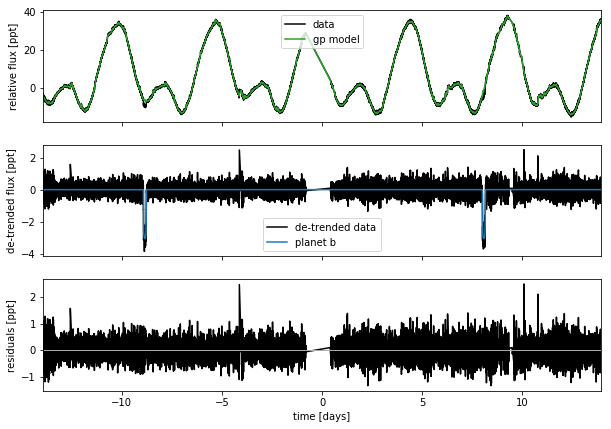

In [24]:
def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = xo.utils.eval_in_model(model.pred, soln, model=model)
    gp_mod += soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    light_curves = xo.utils.eval_in_model(model.light_curves, soln, model=model)
    for i, l in enumerate(["b", ]):
        mod = light_curves[:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(light_curves, axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(model0, map_soln0);

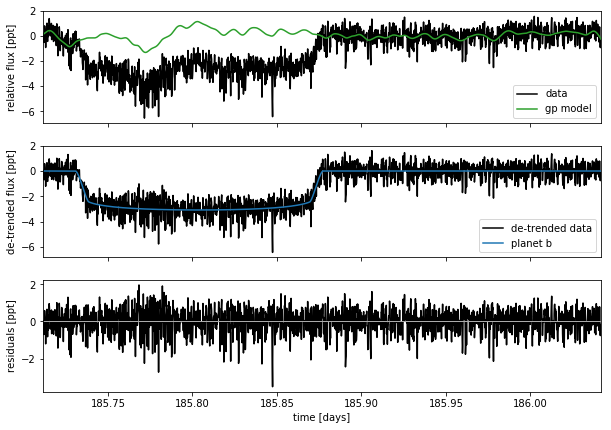

In [25]:
def plot_light_curve_spitzer(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x_spitzer), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x_spitzer[mask], y_spitzer[mask], "k", label="data")
    gp_mod = xo.utils.eval_in_model(model.pred_spitzer, soln, model=model)
    gp_mod += soln["mean_spitzer"]
    ax.plot(x_spitzer[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x_spitzer[mask], y_spitzer[mask] - gp_mod, "k", label="de-trended data")
    light_curves = xo.utils.eval_in_model(model.light_curves_spitzer, soln, model=model)
    for i, l in enumerate(["b"]):
        mod = light_curves[:, i]
        ax.plot(x_spitzer[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(light_curves, axis=-1)
    ax.plot(x_spitzer[mask], y_spitzer[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x_spitzer[mask].min(), x_spitzer[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig

plot_light_curve_spitzer(model0, map_soln0);

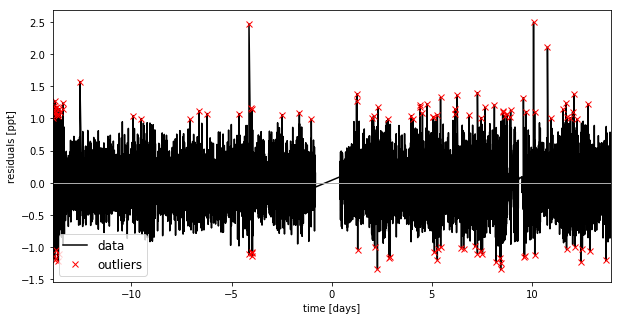

In [26]:
mod = map_soln0["pred"] + map_soln0["mean"] + map_soln0["light_curve"]
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

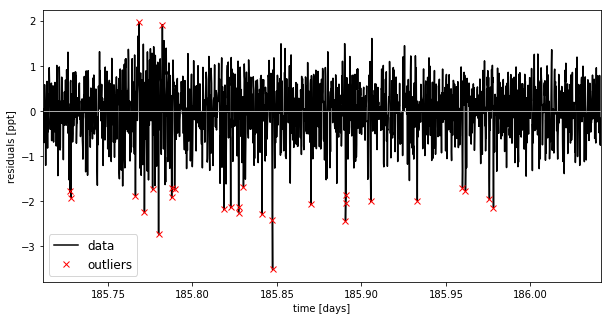

In [27]:
mod = map_soln0["pred_spitzer"] + map_soln0["mean_spitzer"] + map_soln0["light_curve_spitzer"]
resid = y_spitzer - mod
rms = np.sqrt(np.median(resid**2))
mask_spitzer = np.abs(resid) < 4. * rms

plt.figure(figsize=(10, 5))
plt.plot(x_spitzer, resid, "k", label="data")
plt.plot(x_spitzer[~mask_spitzer], resid[~mask_spitzer], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x_spitzer.min(), x_spitzer.max());

optimizing logp for variables: ['logs2', 'mean']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

message: Desired error not necessarily achieved due to precision loss.
logp: -9207.23754727171 -> -9174.200676718867
optimizing logp for variables: ['logw_spitzer', 'logS_spitzer', 'logs2_spitzer', 'mean_spitzer', 'logw', 'logS', 'logs2', 'mean']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Desired error not necessarily achieved due to precision loss.
logp: -9174.200676718867 -> -8963.982321430294
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logamp', 'logs2', 'mean']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

message: Desired error not necessarily achieved due to precision loss.
logp: -8963.982321430294 -> -8955.832992495296
optimizing logp for variables: ['logrho_star', 'b_param_interval__', 'logror_upperbound__']
message: Optimization terminated successfully.
logp: -8955.832992495318 -> -8955.32336815668
optimizing logp for variables: ['t0', 'logP']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Desired error not necessarily achieved due to precision loss.
logp: -8955.32336815668 -> -8955.29035879185
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logamp', 'logs2', 'mean']
message: Optimization terminated successfully.
logp: -8955.290358791866 -> -8955.290295364293
optimizing logp for variables: ['logrho_star', 'b_param_interval__', 'logror_upperbound__']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Desired error not necessarily achieved due to precision loss.
logp: -8955.290295364359 -> -8955.288130550649


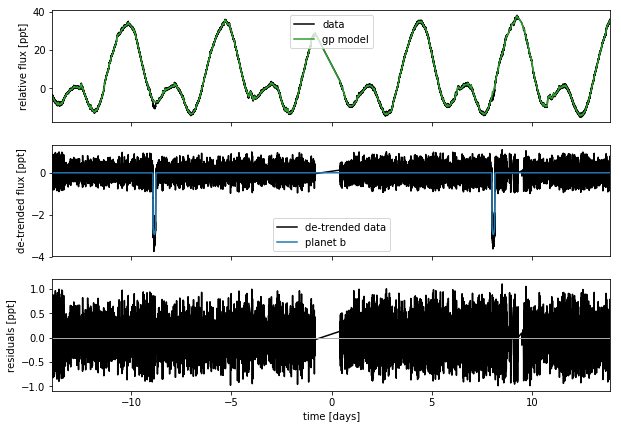

In [28]:
model, map_soln = build_model(mask, mask_spitzer, map_soln0)
fig = plot_light_curve(model, map_soln, mask)
# fig.savefig('gp-map-aumic.png', dpi=200)

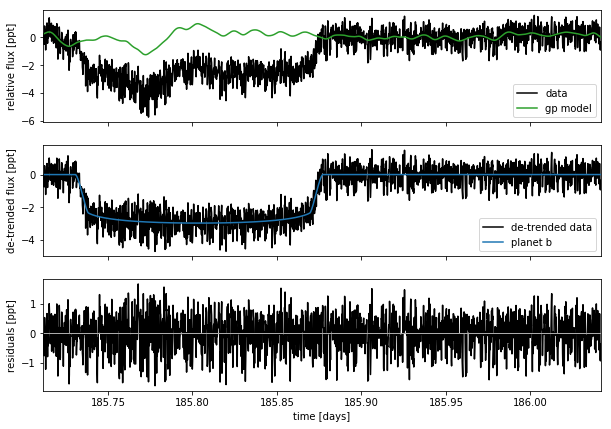

In [30]:
plot_light_curve_spitzer(model, map_soln, mask_spitzer);

In [31]:
# sampler = xo.PyMC3Sampler(window=200, start=500, finish=1000)
sampler = xo.PyMC3Sampler(finish=1000)
with model:
    burnin = sampler.tune(tune=5000, start=map_soln, step_kwargs=dict(target_accept=0.9), )

/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 4 chains: 100%|██████████| 4008/4008 [1:17:12<00:00,  2.16s/draws]


In [32]:
# start, step = sampler._get_start_and_step()
with model:
#     step = pm.NUTS(potential=step.potential, target_accept=0.9)
#     trace = pm.sample(draws=3000, tune=200, step=step, start=start)
    trace = sampler.sample(draws=3000)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, ecc, b_param, logror, t0, logP, logrho_star, r_star, u_star_spitzer, u_star, mix, logdeltaQ, logQ0, logperiod, logamp, logw_spitzer, logS_spitzer, logw, logS, logs2_spitzer, logs2, mean_spitzer, mean]
Sampling 4 chains: 100%|██████████| 12000/12000 [2:54:47<00:00,  1.65s/draws] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [33]:
# pm.summary(trace, varnames= ['b', 'logror', 't0', 'logP', 'ecc', 'omega',
#            'logrho_star', 'r_star', 'u_star', 'u_star_spitzer', 'mix',
#                              'logdeltaQ', 'logQ0', 'logperiod', 'logamp', 'logw', 'logS',
#                              'logs2', 'mean', 'r_ple', 'p_period', 'ror', 'mean_spitzer', 'logs2_spitzer',
#                             'logS_spitzer', 'logw_spitzer', 'rho_star'], alpha=0.317)

In [41]:
pm.summary(trace, varnames= ['b', 'logror', 't0', 'logP', 'ecc', 'omega',
           'logrho_star', 'r_star', 'u_star', 'u_star_spitzer', 'mix',
                             'logdeltaQ', 'logQ0', 'logperiod', 'logamp', 'logw', 'logS',
                             'logs2', 'mean', 'r_ple', 'p_period', 'ror', 'mean_spitzer', 'logs2_spitzer',
                            'logS_spitzer', 'logw_spitzer', 'rho_star'], alpha=0.317)

,mean,sd,mc_error,hpd_15.85,hpd_84.15,n_eff,Rhat
b__0,0.171827,0.114615,1.207078e-03,0.000312,0.225514,7548.780917,0.999878
logror__0,-2.969253,0.024222,2.219358e-04,-2.990492,-2.942350,10155.441819,0.999963
t0__0,-8.849884,0.000698,7.265031e-06,-8.850635,-8.849252,8862.023148,0.999902
logP__0,2.135729,0.000005,5.527544e-08,2.135724,2.135733,8647.642197,0.999919
ecc__0,0.139785,0.118225,1.716811e-03,0.000008,0.174305,3914.839327,1.000179
omega__0,-0.188107,1.863850,2.930067e-02,-3.140943,0.796996,3793.273128,1.000603
logrho_star,0.611478,0.303490,6.343185e-03,0.323009,0.856396,2688.895217,1.001613
r_star,0.750142,0.030254,2.950630e-04,0.719674,0.779849,10285.155139,0.999855
u_star__0,0.243046,0.164785,1.644571e-03,0.002255,0.312808,11207.967628,1.000081
u_star__1,0.007687,0.155895,1.547963e-03,-0.169917,0.136201,10582.732848,0.999891


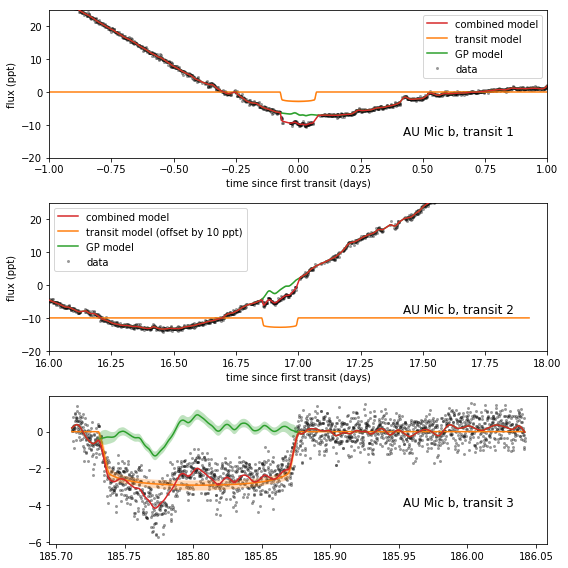

In [43]:
pred = np.percentile(trace["light_curve"] + trace["mean"][:, None] +
                     trace["pred"], [5,50,95], axis=0)
pred1 = np.percentile(trace["light_curve"], [5,50,95], axis=0)
pred2 = np.percentile(trace["pred"] + trace["mean"][:, None], [5,50,95], axis=0)

fig,  [ax1, ax2, ax3] = plt.subplots(3,1, figsize=[8, 8])
time = x[mask] - np.median(trace['t0'][:,0])

ax1.plot(time, pred[1], color='C3', label = 'combined model', zorder=1002)
art = ax1.fill_between(time, pred[0], pred[2], color="C3", alpha=0.3,
                       zorder=1001)
art.set_edgecolor("none")

# ax1.plot(time, pred1[1], color='C1', label = 'transit model')
# art = ax1.fill_between(time, pred1[0], pred1[2], color="C1", alpha=0.3,
#                        zorder=1000)
# art.set_edgecolor("none")
predx = np.percentile(trace["light_curve_transit"], [5,50,95], axis=0)
ax1.plot(np.linspace(-1,1, 1000), predx[1],
            color="C1", label="transit model")
art = ax1.fill_between(np.linspace(-1,1, 1000), predx[0], predx[2], color="C1", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(time, pred2[1], color='C2', label = 'GP model')
art = ax1.fill_between(time, pred2[0], pred2[2], color="C2", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(time, y[mask], ".k", label="data",
         alpha=0.4, zorder=-1000, mec="none")

ax1.set_xlim(-1,1)
ax1.set_ylim(-20, 25)

ax1.legend()
ax1.set_xlabel("time since first transit (days)")
ax1.set_ylabel("flux (ppt)")

ax1.annotate('AU Mic b, transit 1', (0.7, 0.1), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

ax2.plot(time, pred[1], color='C3', label = 'combined model', zorder=1002)
art = ax2.fill_between(time, pred[0], pred[2], color="C3", alpha=0.3,
                       zorder=1001)
art.set_edgecolor("none")

# ax2.plot(time, pred1[1] -10, color='C1', label = 'transit model (offset by 10 ppt)')
# art = ax2.fill_between(time, pred1[0] -10, pred1[2]-10, color="C1", alpha=0.3,
#                        zorder=1000)
# art.set_edgecolor("none")
ax2.plot(np.linspace(-1,1, 1000) + np.median(trace['p_period'])*2, predx[1] - 10,
            color="C1", label="transit model (offset by 10 ppt)")
art = ax2.fill_between(np.linspace(-1,1, 1000) + np.median(trace['t0']),
                       predx[0] -10, predx[2] -10, color="C1", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax2.plot(time, pred2[1], color='C2', label = 'GP model')
art = ax2.fill_between(time, pred2[0], pred2[2], color="C2", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax2.plot(time, y[mask], ".k", label="data",
         alpha=0.4, zorder=-1000, mec="none")

ax2.set_xlim(16,18)
ax2.set_ylim(-20, 25)
ax2.legend()
ax2.set_xlabel("time since first transit (days)")
ax2.set_ylabel("flux (ppt)")

ax2.annotate('AU Mic b, transit 2', (0.7, 0.2), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

# ax3.plot(time, pred[1], color='C3', label = 'combined model')
# art = ax3.fill_between(time, pred[0], pred[2], color="C3", alpha=0.3,
#                        zorder=1000)
# art.set_edgecolor("none")

# ax3.plot(time, pred1[1], color='C1', label = 'transit model')
# art = ax3.fill_between(time, pred1[0], pred1[2], color="C1", alpha=0.3,
#                        zorder=1000)
# art.set_edgecolor("none")

# ax3.plot(time, pred2[1], color='C2', label = 'GP model')
# art = ax3.fill_between(time, pred2[0], pred2[2], color="C2", alpha=0.3,
#                        zorder=1000)
# art.set_edgecolor("none")

# ax3.plot(time, y[mask], ".k", label="data",
#          alpha=0.4, zorder=-1000, mec="none")

# ax3.set_xlim(11, 13)
# ax3.set_ylim(-20, 25)
# ax3.legend()
# ax3.set_xlabel("time since first transit (days)")
# ax3.set_ylabel("flux (ppt)")

# ax3.annotate('AU Mic c, transit 1', (0.7, 0.1), xycoords="axes fraction",
#              xytext=(5, 5), textcoords="offset points",
#              ha="left", va="bottom", fontsize=12)

pred_spitzer = np.percentile(trace["light_curve_spitzer"] + trace["mean_spitzer"][:, None] +
                     trace["pred_spitzer"], [5,50,95], axis=0)
pred1_spitzer = np.percentile(trace["light_curve_spitzer"], [5,50,95], axis=0)
pred2_spitzer = np.percentile(trace["pred_spitzer"] + trace["mean_spitzer"][:, None], [5,50,95], axis=0)


ax3.plot(x_spitzer[mask_spitzer], pred_spitzer[1], color='C3', label = 'combined model', zorder=1002)
art = ax3.fill_between(x_spitzer[mask_spitzer], pred_spitzer[0], pred_spitzer[2], color="C3", alpha=0.3,
                       zorder=1001)
art.set_edgecolor("none")

ax3.plot(x_spitzer[mask_spitzer], pred1_spitzer[1], color='C1', label = 'transit model')
art = ax3.fill_between(x_spitzer[mask_spitzer], pred1_spitzer[0], pred1_spitzer[2], color="C1", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax3.plot(x_spitzer[mask_spitzer], pred2_spitzer[1], color='C2', label = 'GP model')
art = ax3.fill_between(x_spitzer[mask_spitzer], pred2_spitzer[0], pred2_spitzer[2], color="C2", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax3.plot(x_spitzer[mask_spitzer], y_spitzer[mask_spitzer], ".k", label="data",
         alpha=0.4, zorder=-1000, mec="none")

ax3.annotate('AU Mic b, transit 3', (0.7, 0.2), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

plt.tight_layout()
plt.savefig('transits-GP-v3.png', dpi=200)

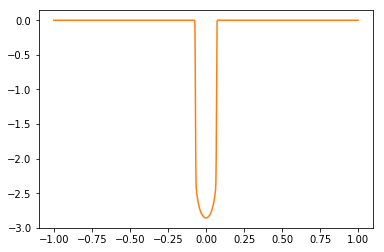

In [37]:
plt.plot(np.linspace(-1,1, 1000), np.percentile(trace["light_curve_transit"], [5,50,95], axis=0)[1],
            color="C1", label="model")

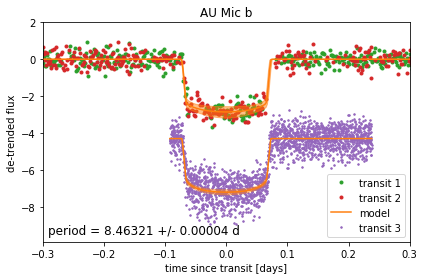

In [44]:
pmask = trace["p_period"][:, 0] < 16.96
for n, letter in enumerate("b"):
    plt.figure()
    
    # Compute the GP prediction
    gp_mod = np.median(trace["pred"][pmask], axis=0)
    offset = np.median(trace["mean"][pmask, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["p_period"][pmask, n])
    t0 = np.median(trace["t0"][pmask, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
#     other = np.median(trace["light_curve"][:, :,], axis=0)

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
    mid = int(np.shape(x[mask])[0] / 2)
    x_fold0 = (x[mask][:mid] - t0 + 0.5*p) % p - 0.5*p
    x_fold1 = (x[mask][mid:] - t0 + 0.5*p) % p - 0.5*p
    if n == 0:
        plt.plot(x_fold0, y[mask][:mid] - gp_mod[:mid] - offset, ".C2", label="transit 1", zorder=-1000)
        plt.plot(x_fold1, y[mask][mid:] - gp_mod[mid:] - offset, ".C3", label="transit 2", zorder=-1000)
    elif n == 1:
        plt.plot(x_fold, y[mask] - gp_mod - offset, ".C2", label="data", zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
#     pred = trace["light_curve"][:, inds][pmask] #- offset # + trace["mean"][:, None] 
#     pred = np.percentile(pred, [16, 50, 84], axis=0)
#     plt.plot(x_fold[inds], pred[1], color="C1", label="model")
#     art = plt.fill_between(x_fold[inds], pred[0],
#                            pred[2], color="C1", alpha=0.5,
#                            zorder=1000)
#     art.set_edgecolor("none")
    pred = np.percentile(trace["light_curve_transit"], [5,50,95], axis=0)
    plt.plot(np.linspace(-1,1, 1000), pred[1],
            color="C1", label="model")
    art = plt.fill_between(np.linspace(-1,1, 1000), pred[0],
                           pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.5f} +/- {1:.5f} d".format(
        np.mean(trace["p_period"][pmask, n]), np.std(trace["p_period"][pmask, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)
    
    gp_mod = np.median(trace["pred_spitzer"][pmask], axis=0)
    offset = np.median(trace["mean_spitzer"][pmask, None])
    
    x_fold = (x_spitzer[mask_spitzer] - t0 + 0.5*p) % p - 0.5*p
#     mid = int(np.shape(x_spitzer)[0] / 2)
#     x_fold0 = (x_spitzer[:mid] - t0 + 0.5*p) % p - 0.5*p
    
    plt.plot(x_fold, y_spitzer[mask_spitzer] - gp_mod - offset - 4.3, ".C4", label="transit 3", zorder=-1000, ms=3)
    
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curve_spitzer"][:, inds][pmask] #- offset # + trace["mean"][:, None] 
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1] - 4.3, color="C1", )
    art = plt.fill_between(x_fold[inds], pred[0] - 4.3,
                           pred[2]-4.3, color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    plt.legend(fontsize=10, loc=4)
    plt.ylim(-9.9,2)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("AU Mic {0}".format(letter));
    plt.xlim(-0.3, 0.3)
    plt.tight_layout()
    plt.savefig('transit-plot-{}.png'.format(n+1), dpi=200)

In [39]:
# n = 0
# resid = y[mask] - trace["pred"] - trace["mean"][:, None]
# p = np.median(trace["p_period"][:, n])
# t0 = np.median(trace["t0"][:, n])
# x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
# plt.plot(x_fold, np.percentile(resid, [16], axis=0), ".C2", label="data", zorder=-1000)
# plt.plot(x_fold, np.percentile(resid, [50], axis=0), ".C2", label="data", zorder=-1000)
# plt.plot(x_fold, np.percentile(resid, [84], axis=0), ".C2", label="data", zorder=-1000)

In [40]:
# pred = np.percentile(resid, [16, 50, 84], axis=0)
# plt.plot(x_fold, pred[1], ".C2", label="data", zorder=-1000)
# plt.xlim(-0.3, 0.3)

In [25]:
map_soln0

{'mean': array(6.52882114),
 'logs2': array(-2.39280003),
 'logS': array(-2.98246078),
 'logw': array(3.37673192),
 'logamp': array(5.03765618),
 'logperiod': array(1.58292243),
 'logQ0': array(2.93485094),
 'logdeltaQ': array(9.9145813),
 'mix_interval__': array(-1.18581046),
 'u_star_quadlimbdark__': array([-0.57536414, -0.69314718]),
 'r_star': array(0.75),
 'logrho_star': array(-0.10536052),
 'logP': array([2.82825524, 3.42921204]),
 't0': array([-8.82244677,  2.9953215 ]),
 'logror_upperbound__': array([0.68895411, 1.26911893]),
 'b_param_interval__': array([-0.78097465, -0.67497811]),
 'ecc_interval__': array([-1.94591015, -1.94591015]),
 'omega_angle__': array([[0., 0.],
        [1., 1.]]),
 'period': array(4.86916485),
 'mix': array(0.23400907),
 'u_star': array([0.4, 0.2]),
 'rho_star': array(0.9),
 'logror': array([-3.19560421, -4.76168937]),
 'ror': array([0.04094178, 0.00855115]),
 'b_param': array([0.31410987, 0.33738306]),
 'b': array([0.32697008, 0.34026807]),
 'ecc': ar

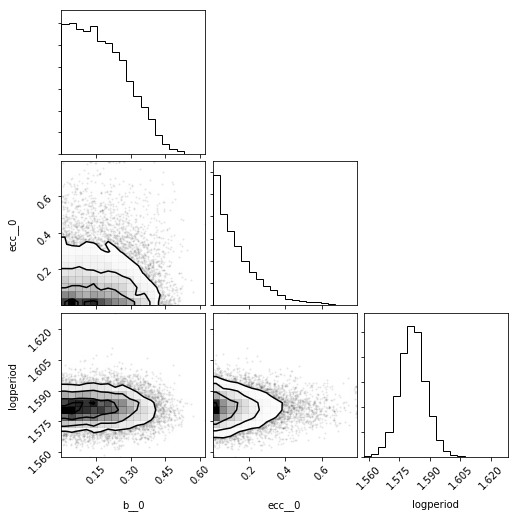

In [103]:
import corner
varnames = ["b", "ecc", 'logperiod']
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples);



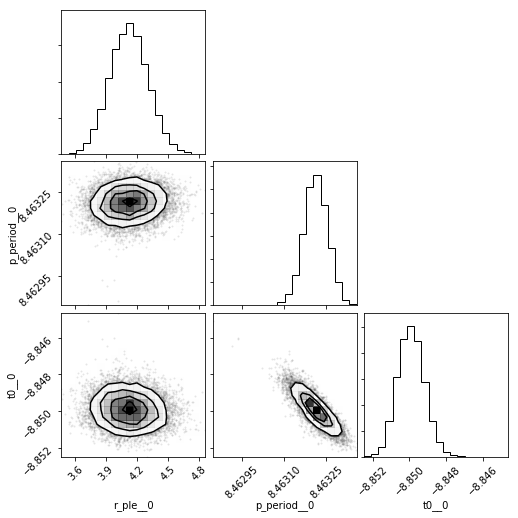

In [104]:
import corner
varnames = ["r_ple", "p_period", 't0']
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples);


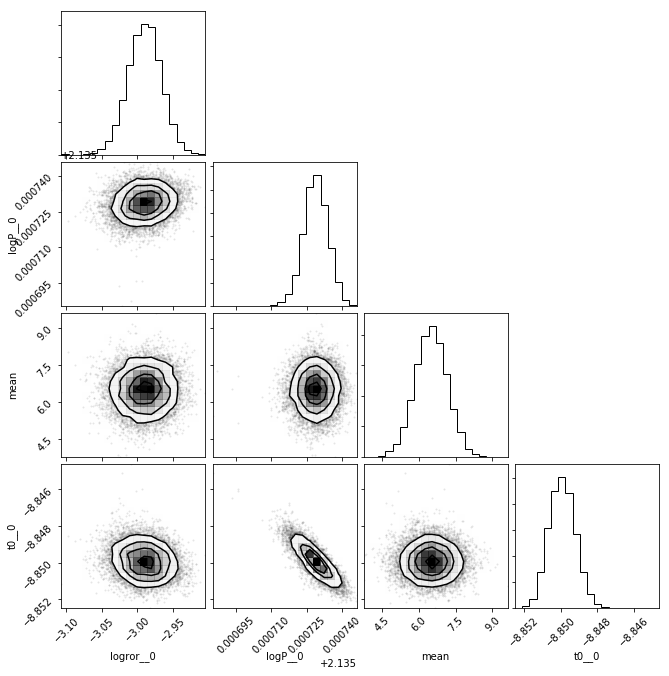

In [105]:
import corner
varnames = ["logror", "logP", 'mean', 't0']
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples);

In [32]:
pm.save_trace(trace)

'.pymc_2.trace'

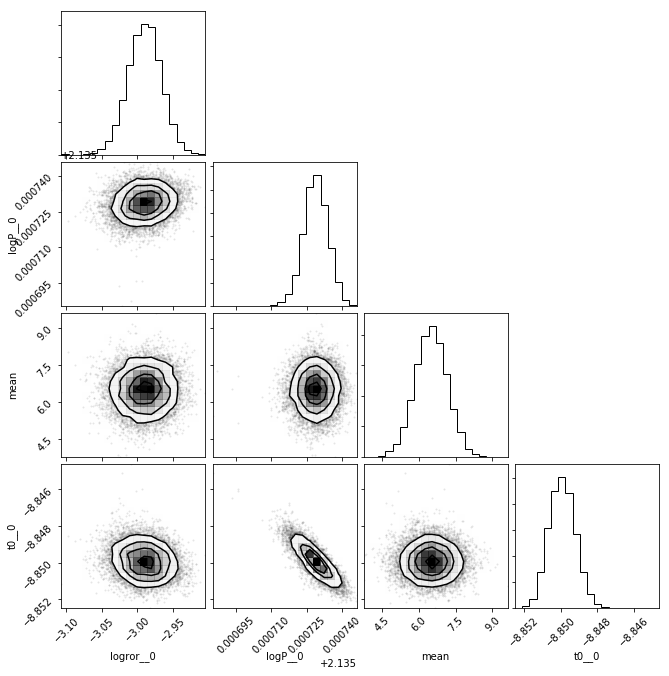

In [106]:
import corner
varnames = ["logror", "logP", 'mean', 't0']
samples = pm.trace_to_dataframe(trace, varnames=varnames)
# samples = samples.loc[samples.logP__0 < 2.8304]
corner.corner(samples);

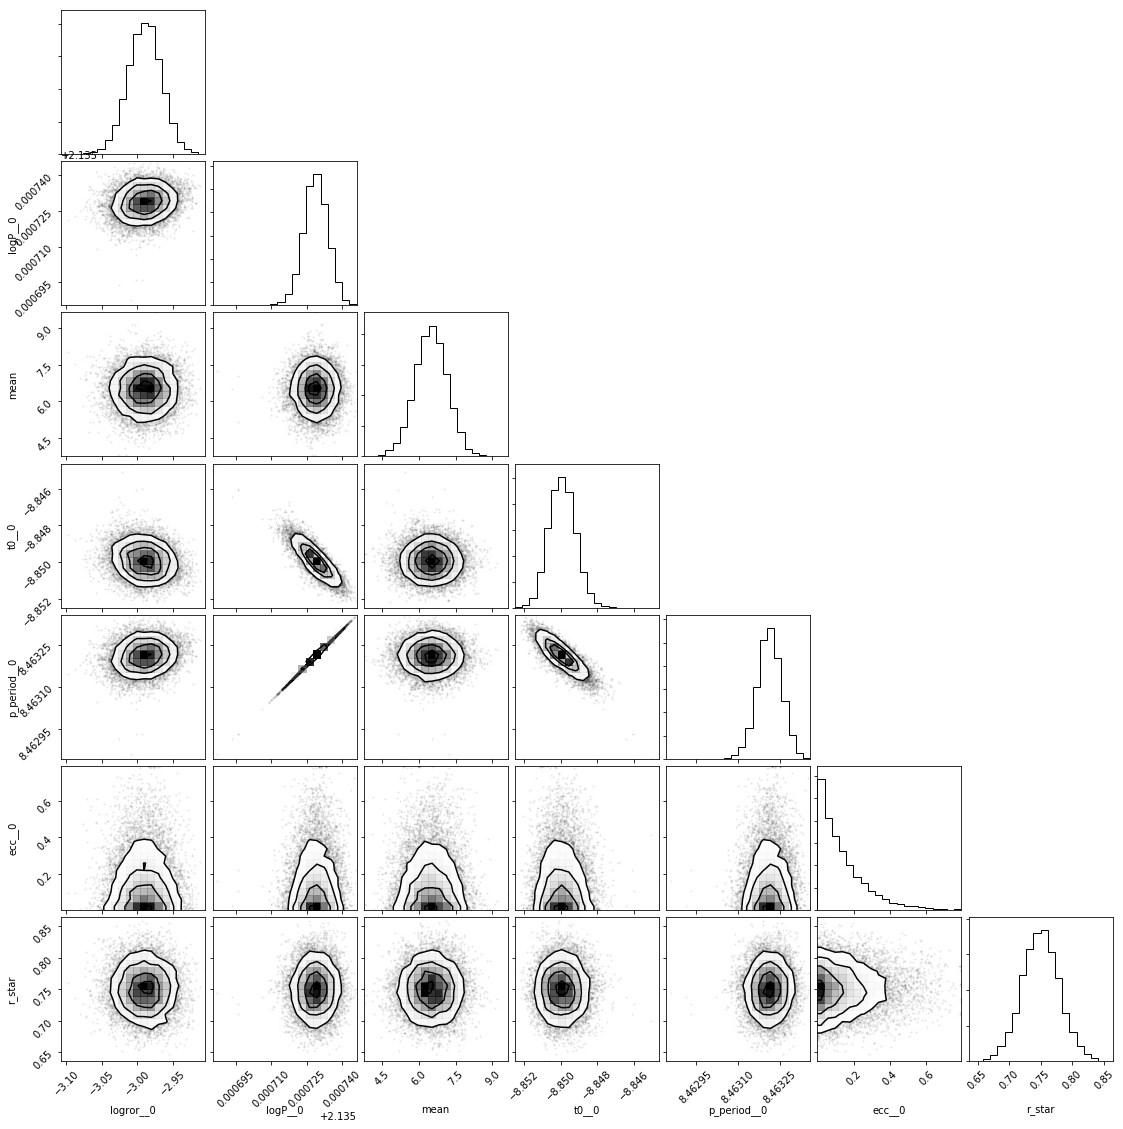

In [107]:
import corner
varnames = ["logror", "logP", 'mean', 't0', 'p_period', 'ecc', 'r_star']
samples = pm.trace_to_dataframe(trace, varnames=varnames)
# samples = samples.loc[samples.logP__0 < 2.8304]
corner.corner(samples);

In [94]:
pm.save_trace(trace)

'.pymc_1.trace'

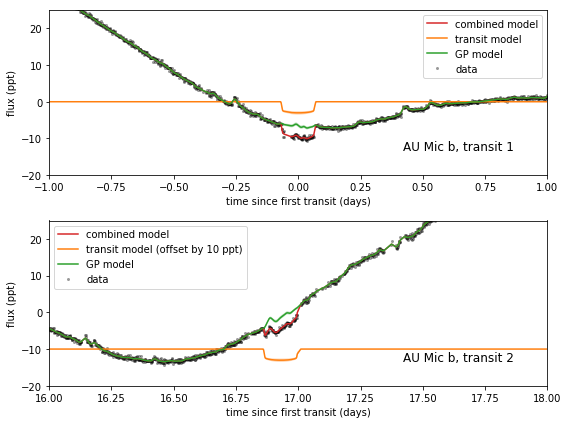

In [35]:
pmask = trace["p_period"][:, 0] < 16.96
pred = np.percentile(trace["light_curve"][pmask] + trace["mean"][pmask, None] +
                     trace["pred"][pmask], [5,50,95], axis=0)
pred1 = np.percentile(trace["light_curve"][pmask], [5,50,95], axis=0)
pred2 = np.percentile(trace["pred"][pmask] + trace["mean"][pmask, None], [5,50,95], axis=0)

fig,  [ax1, ax2] = plt.subplots(2,1, figsize=[8, 6])
time = x[mask] - np.median(trace['t0'][pmask,0])

ax1.plot(time, pred[1], color='C3', label = 'combined model')
art = ax1.fill_between(time, pred[0], pred[2], color="C3", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(time, pred1[1], color='C1', label = 'transit model')
art = ax1.fill_between(time, pred1[0], pred1[2], color="C1", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(time, pred2[1], color='C2', label = 'GP model')
art = ax1.fill_between(time, pred2[0], pred2[2], color="C2", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(time, y[mask], ".k", label="data",
         alpha=0.4, zorder=-1000, mec="none")

ax1.set_xlim(-1,1)
ax1.set_ylim(-20, 25)

ax1.legend()
ax1.set_xlabel("time since first transit (days)")
ax1.set_ylabel("flux (ppt)")

ax1.annotate('AU Mic b, transit 1', (0.7, 0.1), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

ax2.plot(time, pred[1], color='C3', label = 'combined model')
art = ax2.fill_between(time, pred[0], pred[2], color="C3", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax2.plot(time, pred1[1] -10, color='C1', label = 'transit model (offset by 10 ppt)')
art = ax2.fill_between(time, pred1[0] -10, pred1[2]-10, color="C1", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax2.plot(time, pred2[1], color='C2', label = 'GP model')
art = ax2.fill_between(time, pred2[0], pred2[2], color="C2", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax2.plot(time, y[mask], ".k", label="data",
         alpha=0.4, zorder=-1000, mec="none")

ax2.set_xlim(16,18)
ax2.set_ylim(-20, 25)
ax2.legend()
ax2.set_xlabel("time since first transit (days)")
ax2.set_ylabel("flux (ppt)")

ax2.annotate('AU Mic b, transit 2', (0.7, 0.1), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

# ax3.plot(time, pred[1], color='C3', label = 'combined model')
# art = ax3.fill_between(time, pred[0], pred[2], color="C3", alpha=0.3,
#                        zorder=1000)
# art.set_edgecolor("none")

# ax3.plot(time, pred1[1], color='C1', label = 'transit model')
# art = ax3.fill_between(time, pred1[0], pred1[2], color="C1", alpha=0.3,
#                        zorder=1000)
# art.set_edgecolor("none")

# ax3.plot(time, pred2[1], color='C2', label = 'GP model')
# art = ax3.fill_between(time, pred2[0], pred2[2], color="C2", alpha=0.3,
#                        zorder=1000)
# art.set_edgecolor("none")

# ax3.plot(time, y[mask], ".k", label="data",
#          alpha=0.4, zorder=-1000, mec="none")

# ax3.set_xlim(11, 13)
# ax3.set_ylim(-20, 25)
# ax3.legend()
# ax3.set_xlabel("time since first transit (days)")
# ax3.set_ylabel("flux (ppt)")

# ax3.annotate('AU Mic c, transit 1', (0.7, 0.1), xycoords="axes fraction",
#              xytext=(5, 5), textcoords="offset points",
#              ha="left", va="bottom", fontsize=12)

plt.tight_layout()
plt.savefig('transits-GP-v3.png', dpi=200)

In [72]:
q = xo.get_samples_from_trace(trace)

In [75]:
[q1 for q1 in q]

[{'mean': 5.794966477209423,
  'logs2': -2.275282881036092,
  'logS': -5.54786944911264,
  'logw': 4.368410183650764,
  'logamp': 5.54852271394925,
  'logperiod': 1.5897022929752058,
  'logQ0': 2.713620405395783,
  'logdeltaQ': 14.956292247499338,
  'mix_interval__': -0.185577231774714,
  'u_star_quadlimbdark__': array([-1.49008246,  2.01031012]),
  'r_star': 0.6473386190305892,
  'logrho_star': 0.12807397224056238,
  'logP': array([2.83186698, 3.56742246]),
  't0': array([-8.87863403,  2.9702218 ]),
  'logror_upperbound__': array([0.61586969, 1.04978833]),
  'b_param_interval__': array([-1.21898733,  1.37901562]),
  'ecc_interval__': array([ 0.12097776, -0.31840324]),
  'omega_angle__': array([[-0.65329057, -1.12198123],
         [ 0.03426459, -0.35292403]]),
  'period': 4.90228926510961,
  'mix': 0.4537383825490712,
  'u_star': array([ 0.75637836, -0.32753183]),
  'rho_star': 1.1366370791788123,
  'logror': array([-3.05523873, -4.06101912]),
  'ror': array([0.04711147, 0.01723145]),


(-20, 25)

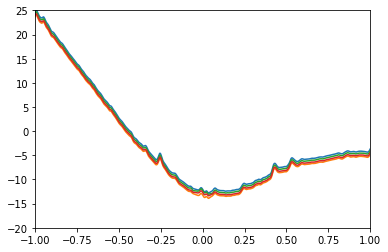

In [52]:
plt.plot(time, trace.get_values('pred', burn=1000, chains=[2])[1])
plt.plot(time, trace.get_values('pred', burn=1000, chains=[2])[100])
plt.plot(time, trace.get_values('pred', burn=1000, chains=[2])[1000])
plt.plot(time, trace.get_values('pred', burn=1000, chains=[2])[1500])
plt.xlim(-1, 1)
plt.ylim(-20, 25)

In [113]:
i = 1000
logS = trace.get_values('logS', burn=1000, chains=[2])[i]
logw = trace.get_values('logw', burn=1000, chains=[2])[i]
logamp = trace.get_values('logamp', burn=1000, chains=[2])[i]
period = trace.get_values('period', burn=1000, chains=[2])[i]
logQ0 = trace.get_values('logQ0', burn=1000, chains=[2])[i]
logdeltaQ = trace.get_values('logdeltaQ', burn=1000, chains=[2])[i]
mix = trace.get_values('mix', burn=1000, chains=[2])[i]
logs2 = trace.get_values('logs2', burn=1000, chains=[2])[i]
mean = trace.get_values('mean', burn=1000, chains=[2])[i]
light_curve = trace.get_values('light_curve', burn=1000, chains=[2])[i]

In [114]:
term1 = xo.gp.terms.SHOTerm(log_S0=logS, log_w0=logw, Q=1/np.sqrt(2))
term2 = xo.gp.terms.RotationTerm(
    log_amp=logamp,
    period=period,
    log_Q0=logQ0,
    log_deltaQ=logdeltaQ,
    mix=mix
)

In [115]:
kernel = term1 + term2
gp = xo.gp.GP(kernel, x[mask], yerr[mask]**2 + tt.exp(logs2), J=6)

In [116]:
yvals = y[mask] - mean - light_curve
xvals = x[mask]
gp.predict(xvals[0:10])

INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock


AttributeError: 'GP' object has no attribute 'z'

In [38]:
samples = pm.trace_to_dataframe(trace)

In [45]:
q = np.percentile(samples.loc[:, ['p_period__1', 'r_ple__1', 't0__1', 'ror__1', 'b__1', 'ecc__1']], [16,50,84], axis=0)

In [46]:
print(q[1])
print(q[2] - q[1])
print(q[1] - q[0])

[3.03994050e+01 1.85001541e+00 2.98026113e+00 2.27642613e-02
 5.23014074e-01 1.66769492e-01]
[6.54367416 0.78297107 0.038619   0.00936811 0.27843932 0.23252138]
[5.25367695 1.523447   0.02495522 0.01876242 0.34476662 0.12670708]


In [47]:
np.percentile(samples.loc[:, ['t0__1']], [16,50,84], axis=0) + ref_time

array([[1342.19674843],
       [1342.22170366],
       [1342.26032265]])

In [49]:
1342.26032265- 1342.22170366

0.03861899000003177

In [50]:
1342.22170366-1342.19674843

0.02495522999993227

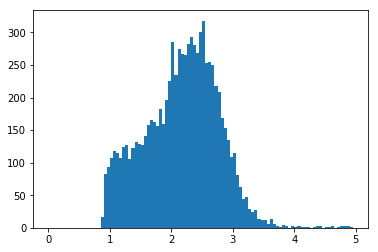

In [66]:
plt.hist(samples.loc[samples.logror__1 > -4.5, 'r_ple__1'],bins=np.arange(0,5,0.05));

In [53]:
plt.hist(samples.loc[:, 'logror__1'],bins=np.arange(-9,-2,0.05));

KeyError: 'logror__1'

In [73]:
np.percentile(samples.loc[samples.logror__1 > -4.5, 'p_period__1'], [16,50,84])

array([25.02009874, 30.17751827, 36.7597901 ])

In [71]:
2.75476141-2.22395897

0.53080244

In [ ]:
from scipy.optimize import curve_fit

ytt,xtt,_= plt.hist(samples.loc[: 'p_period__1'],100,alpha=.3,label='data')

xtt=(xtt[1:]+xtt[:-1])/2 # for len(x)==len(y)

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

expected=(1,.2,250,2,.2,125)
params,cov=curve_fit(bimodal,xtt,ytt,expected)
sigma=np.sqrt(np.diag(cov))
plt.plot(xtt,bimodal(xtt,*params),color='red',lw=3,label='model')
legend()
print(params,'\n',sigma)  

KeyboardInterrupt: 

In [9]:
spitzer = pd.read_csv('spitzer.csv')

SyntaxError: invalid syntax (<ipython-input-11-f686442465f1>, line 1)

In [13]:
from astropy.time import Time

In [10]:
st = Time(spitzer.BMJD, format='mjd', scale='tdb')
time_spit = st.jd - 2457000

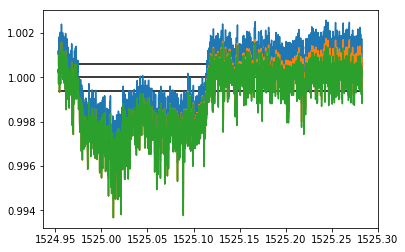

In [20]:
plt.plot(time_spit, spitzer.SAP_flux)
plt.plot(time_spit, spitzer.SAP_pld)
plt.plot(time_spit, spitzer.SAP_pld_ramp)

plt.hlines(spitzer.SAP_pld_ramp[1500:2000].mean(), time_spit.min(), time_spit.max())
plt.hlines(spitzer.SAP_pld_ramp[1500:2000].mean()+spitzer.SAP_pld_ramp[1500:2000].std(),
           time_spit.min(), time_spit.max())
plt.hlines(spitzer.SAP_pld_ramp[1500:2000].mean()-spitzer.SAP_pld_ramp[1500:2000].std(),
           time_spit.min(), time_spit.max())

In [21]:
spitzer.SAP_pld_ramp[1500:2000].std()

0.0006285249731535076

In [22]:
flux_err

array([0.00021623, 0.00020605, 0.00020641, ..., 0.00022084, 0.00022095,
       0.00022104], dtype=float32)

In [25]:
np.diff(time_spit) * 86400

array([13.74951303, 13.85842413, 14.09680545, ..., 13.81927729,
       13.74657601, 14.19268101])

In [45]:
y_spitzer.values

array([ 0.26496245,  0.22736398,  0.36988758, ..., -1.17720462,
       -0.70826838, -0.75519954])

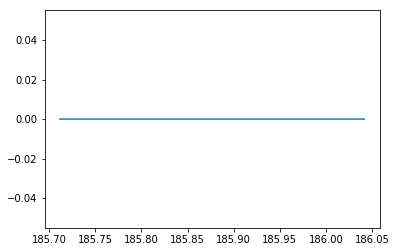

In [33]:
plt.plot(x_spitzer, map_soln0['light_curve_spitzer'])

In [30]:
-8.8343251 + (8.4633*23)

185.8215749

In [26]:
texp, texp_spitzer

(0.001388888888888889, 0.00016070157289505005)

In [84]:
with model0:
    orbit = xo.orbits.KeplerianOrbit(
                r_star=map_soln0['r_star'],
                period=map_soln0['p_period'], t0=map_soln0['t0'], b=map_soln0['b'],
                rho_star=map_soln0['rho_star'], ecc=map_soln0['ecc'], omega=map_soln0['omega'])
    lc = xo.StarryLightCurve(map_soln0['u_star_spitzer']).get_light_curve(
                orbit=orbit, r=map_soln0['r_pl'], t=np.arange(184,188,0.01), texp=texp)*1e3
    

In [85]:
q = lc.eval()

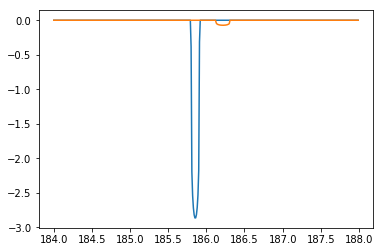

In [86]:
plt.plot(np.arange(184,188,0.01), q)

In [97]:
map_soln0['t0'][0] + (map_soln0['p_period'][0] * 23)

185.80899999999997

In [95]:
map_soln0['p_period'][0]

8.463

In [114]:
pred_spitzer

NameError: name 'pred_spitzer' is not defined

In [159]:
np.percentile(trace['t0'] + ref_time + 2457000, [5, 50, 95])

SyntaxError: unexpected EOF while parsing (<ipython-input-159-6e0798fe92b4>, line 1)

In [116]:
(2458330.3915026 - 2458330.39038031) 

96.96587920188904

In [125]:
np.percentile(trace['ecc'], [5, 50, 86])

array([0.00600421, 0.10271448, 0.27515577])

In [119]:
8.46321149-8.46313939

7.210000000057448e-05

In [122]:
0.18*24

4.32

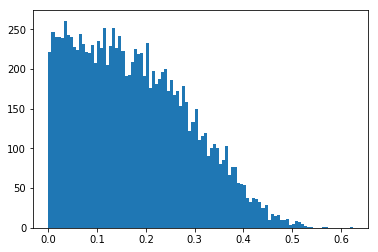

In [135]:
plt.hist(trace['b'], bins=100);

array([-9.149918  , -9.1493174 , -9.1487168 , -9.1481162 , -9.1475156 ,
       -9.146915  , -9.1463144 , -9.1457138 , -9.1451132 , -9.14451259,
       -9.14391199, -9.14331139, -9.14271079, -9.14211019, -9.14150959,
       -9.14090899, -9.14030839, -9.13970779, -9.13910719, -9.13850659,
       -9.13790599, -9.13730539, -9.13670479, -9.13610419, -9.13550359,
       -9.13490298, -9.13430238, -9.13370178, -9.13310118, -9.13250058,
       -9.13189998, -9.13129938, -9.13069878, -9.13009818, -9.12949758,
       -9.12889698, -9.12829638, -9.12769578, -9.12709518, -9.12649458,
       -9.12589398, -9.12529338, -9.12469277, -9.12409217, -9.12349157,
       -9.12289097, -9.12229037, -9.12168977, -9.12108917, -9.12048857,
       -9.11988797, -9.11928737, -9.11868677, -9.11808617, -9.11748557,
       -9.11688497, -9.11628437, -9.11568377, -9.11508317, -9.11448256,
       -9.11388196, -9.11328136, -9.11268076, -9.11208016, -9.11147956,
       -9.11087896, -9.11027836, -9.10967776, -9.10907716, -9.10